In [55]:
import pandas as pd
import geopandas as gpd
from geopandas.geoseries import Point
import numpy as np

city = 'bristol'

lsoa_shp_df = gpd.read_file('full2/england_lsoa_2011_gen.shp')
cityshape   = lsoa_shp_df[lsoa_shp_df['name'].str.contains(city.title())].to_crs({'init': 'epsg:4326'})   




In [56]:
def load_shp():
    
    lsoa_shp_df = gpd.read_file('full2/england_lsoa_2011_gen.shp')
    return lsoa_shp_df[lsoa_shp_df['name'].str.contains(city.title())].to_crs({'init': 'epsg:4326'})  


In [57]:
def coordinates_to_lsoa(lats, lons, cityshape):
    
    poly = (0,0)
    
    try:
        pnt = Point(lons, lats)
        query_df = cityshape[cityshape.contains(pnt)]
        if query_df.shape[0] == 1:
            poly = (query_df.iloc[0]['name'], query_df.iloc[0]['geometry'])
    except Exception as exception:
        pass
    
    return poly
    
                    
#name, a = coordinates_to_lsoa(51.42975886130622, -2.614136701775307,  cityshape) 


In [58]:
def get_venues_coordinates(city, outfolder):

    venues_coordinates = {}

    for ind, line in enumerate(open(outfolder + '/user_info/' + city + '_user_venues_full_locals_filtered.dat')):
        #if ind == 10: break
        fields = line.strip().split('\t')
        venues = [fff.split(',') for fff in fields[1:]]

        for v in venues:
            venues_coordinates[v[0]] = (float(v[1]), float(v[2]))

    return venues_coordinates


In [5]:
def get_lsoa_venues(venues_coordinates):
    
    lsoa_venues  = {}
    lsoa_polygons = {}

    for ind, (v, c) in enumerate(venues_coordinates.items()):
        #if ind == 50: break
        
        lsoa, polygon = coordinates_to_lsoa( c[1], c[0], cityshape )

        if lsoa != 0:          
                   
            if lsoa not in lsoa_polygons:
                lsoa_polygons[lsoa] = polygon    
            
            if lsoa not in lsoa_venues:
                lsoa_venues[lsoa] = [v]
            else:
                lsoa_venues[lsoa].append(v)
        
    return lsoa_venues, lsoa_polygons

#lsoa_venues, lsoa_polygons = get_lsoa_venues(venues_coordinates)


In [59]:
def get_edge_weights(city, outfolder):
    
    edges_weights = {}
    all_edges   = set()
    
    for ind,line in enumerate(open(outfolder + 'networks/gephi/' + city + '_venues_similarity_edges.dat')):
       # if ind == 10: break
        if 'Target' not in line:
            source, target, distance, weight, t = line.strip().split('\t')
            
            weight = float(weight)
            edge   = '_'.join(sorted([source, target]))
            edges_weights[edge] = weight
            all_edges.add(source)
            all_edges.add(target)
            
    return edges_weights
 


In [60]:
def get_node_edge_list(edges_weights):

    # for each node list the edges (weights) in which they are present
    nodes_edge_weights = {}
    
    for ind, (e, w) in enumerate(edges_weights.items()):
    
        #if ind == 100: break
            
        e1, e2 = e.split('_')
        
        if e1 not in nodes_edge_weights:
            nodes_edge_weights[e1] = [(e2, w)]
        else:
            nodes_edge_weights[e1].append((e2, w))

                    
        if e2 not in nodes_edge_weights:
            nodes_edge_weights[e2] = [(e1, w)]
        else:
            nodes_edge_weights[e2].append((e1, w))
        
    return nodes_edge_weights
    
    
#nodes_edge_weights = get_node_edge_list(edges_weights)



In [11]:
def get_lsoa_mininw_edges(lsoa_venues):
    
    lsoa_edges = {}

    for ind, (lsoa, venues) in enumerate(lsoa_venues.items()):
        #if ind == 10: break

        for v1 in venues:
            for v2 in venues:
                if v1 != v2:
                    edge = '_'.join(sorted([v1,v2]))

                    if edge in edges_weights:

                        weight = edges_weights[edge]    

                        if lsoa not in lsoa_edges:
                            lsoa_edges[lsoa] = [(edge, weight)]
                        else:
                            lsoa_edges[lsoa].append((edge, weight))

    return lsoa_edges


In [13]:
city               = 'bristol'
outfolder          = '../ProcessedData/' + city + '/'

#cityshape                   = load_shp()
#venues_coordinates          = get_venues_coordinates(city, outfolder)
#lsoa_venues, lsoa_polygons  = get_lsoa_venues(venues_coordinates)
#all_venues                  = set([venue for venues in lsoa_venues.values() for venue in venues])
edges_weights               = get_edge_weights(city, outfolder)     # node1_node2 -> weight
nodes_edge_weights          = get_node_edge_list(edges_weights)     # node0 -> [(node1, w1), (node2, w2), ...]
lsoa_edges                  = get_lsoa_mininw_edges(lsoa_venues)    # edges within the mini lsoa level networks

In [ ]:
''' GET FRIENDSHIP NETWORK DATA ON THE LSOA LEVEL '''



In [61]:
def get_venues_users(outfolder, city):
    
    venues_users = {}
    
    for ind, line in enumerate(open(outfolder + '/venues_info/' + city + '_venues_users.dat')):
        
        #if ind == 10: break
        fields = line.strip().split('\t')
        venue  = fields[0]
        users  = fields[1:]
        
        venues_users[venue] = users
        
    return venues_users
        


def get_users_friends(outfolder, city):
    
    friends_list = {}
    
    for ind, line in enumerate(open( outfolder + 'networks/gephi/' + city + '_friendship_edges.dat')):
 
        if 'Source' not in line:
        
       #     if ind == 10: break
        
            source, target, a, b, c = line.strip().split('\t')
            
            if source not in friends_list:
                friends_list[source] = [target]
            else:
                friends_list[source].append(target)
            
        
            if target not in friends_list:
                friends_list[target] = [source]
            else:
                friends_list[target].append(source)

    return friends_list
        

venues_users = get_venues_users(outfolder, city)   
friends_list = get_users_friends(outfolder, city)
#print venues_users

In [49]:
def get_friendship_ties_within_lsoa(lsoa_venues, venues_users, friends_list):
    
    lsoa_friendships = {}
    lsoa_num_users   = {}
    
    
    for ind, (lsoa, venues) in enumerate(lsoa_venues.items()):
        
        #if ind == 10 : break
        users = []
        for venue in venues:
            users += venues_users[venue]
    
    
        lsoa_num_users[lsoa] = len(users)
    
        for u1 in users:
            if u1 in friends_list:
                for u2 in users:
                    if u1 != u2:
                        if u2 in friends_list:
                            edge = '_'.join(sorted([u1, u2]))
    
                            if lsoa not in lsoa_friendships:
                                lsoa_friendships[lsoa] = [edge]
                            else:
                                lsoa_friendships[lsoa].append(edge)
    
    
    return lsoa_num_users, lsoa_friendships

lsoa_num_users, lsoa_friendships = get_friendship_ties_within_lsoa(lsoa_venues, venues_users, friends_list)

In [63]:
def get_lsoa_nw_features(lsoa_edges, edges_weights):


    all_edges = [set(e.split('_')) for e in edges_weights.keys()]
    all_nodes = list(([ e.split('_')[0]  for e in edges_weights.keys()] + [ e.split('_')[1]  for e in edges_weights.keys()]))
    NNN       = len(all_nodes)

    edge_avg_weight_glb = np.mean(edges_weights.values())                # global avg weight
    edge_density_glb    = len(all_edges) / ( NNN * (NNN - 1) / 2.0 )     # number of existing edges out 

    lsoa_weights_density = {}
    
    for ind, (lsoa, venues) in enumerate(lsoa_venues.items()):

        #if ind == 100: break

        # edge types
        #   - within the lsoa
        #   - on the boundary (one node wihtin, other outside)
        #   - outside of the lsoa (both nodes outside)
        # that didnt work out (computationally)  --> comparing lsoa level stuff to the global stuff

        edge_num               = 0.0            # number of edges within the lsoa
        node_num               = len(venues)    # number of nodes (venues) within the lsoa
        edge_avg_weight_in     = 0.0            # avg edge weight within the lsoa
        edge_density_in        = 0.0            # number of existing edges within lsoa out of possible ones


        venue_num = len(venues)

        if venue_num > 1 and lsoa in lsoa_edges:

            weights  = [e[1] for e in lsoa_edges[lsoa]]
            edges    = [e[0] for e in lsoa_edges[lsoa]]   
            nodes    = venues

            edge_num            = len(weights)    
            edge_avg_weight_in  = sum(weights) / edge_num 
            edge_density_in     = edge_num / ( venue_num * (venue_num - 1 ) / 2.0  )

            lsoa_weights_density[lsoa] = (edge_avg_weight_in, edge_density_in)
            
            #print round(edge_avg_weight_in, 2), round(edge_avg_weight_glb, 2), '\t', round(edge_density_in, 2), edge_density_glb, 2

    return lsoa_weights_density, edge_density_glb, edge_avg_weight_glb


lsoa_weights_density, edge_density_glb, edge_avg_weight_glb = get_lsoa_nw_features(lsoa_edges, edges_weights)

In [74]:

def get_venues_features(lsoa_num_users, lsoa_friendships):

    venues_features = {}

    for ind, (lsoa, venues) in enumerate(lsoa_venues.items()):
 
        polygon     = lsoa_polygons[lsoa]
        bounds      = polygon.bounds
        lng0        = bounds[0]
        lat0        = bounds[1]
        lng1        = bounds[2]
        lat1        = bounds[3]
        length      = polygon.length
        area        = polygon.area
        usersnum    = 0
        friendships = 0
        
        if lsoa in lsoa_weights_density:
            lsoa_weight = lsoa_weights_density[lsoa][0]
            lsoa_dens   = lsoa_weights_density[lsoa][1]
        else:
            lsoa_weight = 0.0
            lsoa_dens   = 0.0
            
        if lsoa in lsoa_num_users:
            usersnum = lsoa_num_users[lsoa]
            
        if lsoa in lsoa_friendships:
            friendships = len(set(lsoa_friendships[lsoa]))
  
        if area < 0.01:

            for venue in venues:

                feats = { 'bnds_lng0'       : bounds[0],
                          'bnds_lat0'       : bounds[1],
                          'bnds_lng1'       : bounds[2],
                          'bnds_lat1'       : bounds[3],
                          'bnds_length'     : polygon.length,
                          'bnds_area'       : polygon.area,
                          'lsoa_weight'     : lsoa_weight,
                          'lsoa_dens'       : lsoa_dens,
                          'lsoa_rel_weight' : lsoa_weight / edge_avg_weight_glb,
                          'lsoa_rel_dens'   : lsoa_dens   / edge_density_glb,
                          'usersnum'        : usersnum,
                          'friendships'     : friendships
                        }

                venues_features[venue] = feats

            

    
    filename = outfolder + 'networks/' + city  + '_LSOA_networkmeasures.csv'  
    df = pd.DataFrame.from_dict(venues_features, orient = 'index')
    df.to_csv(filename, sep = '\t')
    
    return df
    
venues_features_df = get_venues_features(lsoa_num_users, lsoa_friendships)      

/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # Remove the CWD from sys.path while we load stuff.


0 bnds_area
1 bnds_length
2 friendships
3 livingthere
4 lsoa_dens
5 lsoa_rel_dens
6 lsoa_rel_weight
7 lsoa_weight
8 lsoafriends
9 userslikingnum


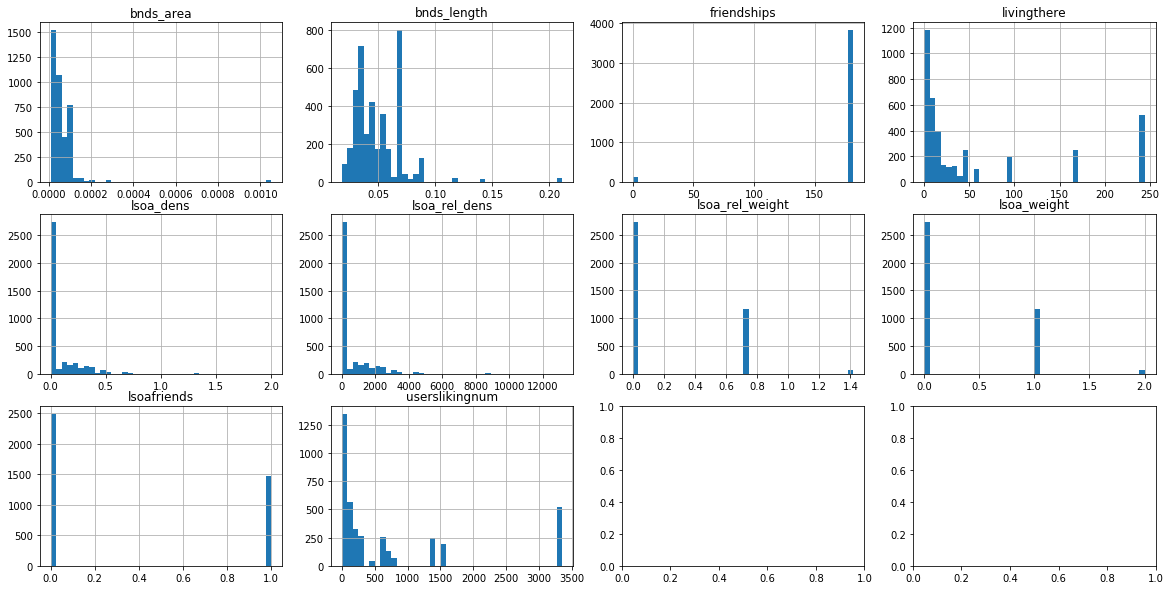

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

city               = 'bristol'
outfolder          = '../ProcessedData/' + city + '/'
infile = outfolder + 'networks/' + city  + '_LSOA_networkmeasures.csv'  


venues_features_df = pd.DataFrame.from_csv(infile, sep = '\t')


ff, ax   = plt.subplots(3, 4, figsize=(20, 10))
indicies = [(i,j) for i in range(3) for j in range(4)]

for ind, column in enumerate(sorted([lll for lll in venues_features_df if 'lng' not in lll and 'lat' not in lll] )):
    i, j = indicies[ind]
    venues_features_df[column].hist(bins = 40, ax = ax[i,j])
    ax[i,j].set_title(column, fontsize = 12)


#ax[0,0].set_yscale('log') 




In [21]:
venues_features_df['lsoa_weight']

4b058834f964a52038b822e3    0.0
4b058834f964a5203ab822e3    0.0
4b058834f964a5203bb822e3    1.0
4b058834f964a5203eb822e3    1.0
4b058834f964a5203fb822e3    0.0
4b058834f964a52040b822e3    0.0
4b058834f964a52047b822e3    0.0
4b058834f964a5204bb822e3    0.0
4b058835f964a52056b822e3    0.0
4b058835f964a52059b822e3    0.0
4b058835f964a5205bb822e3    1.0
4b058835f964a5205db822e3    1.0
4b058835f964a52063b822e3    1.0
4b058835f964a52064b822e3    0.0
4b058835f964a5207bb822e3    1.0
4b058835f964a5207db822e3    0.0
4b058835f964a52083b822e3    0.0
4b058836f964a52092b822e3    0.0
4b058836f964a52096b822e3    1.0
4b058836f964a52099b822e3    1.0
4b058836f964a5209db822e3    0.0
4b058836f964a520a3b822e3    0.0
4b058836f964a520a5b822e3    0.0
4b058836f964a520a6b822e3    0.0
4b058836f964a520a7b822e3    0.0
4b058836f964a520abb822e3    0.0
4b058836f964a520acb822e3    0.0
4b058836f964a520adb822e3    1.0
4b058836f964a520afb822e3    0.0
4b058836f964a520b0b822e3    1.0
                           ... 
5916f368